# Importing Necessary Libraries

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Loading Dataset

In [2]:
data_dir = 'C:\\Users\\momin\\Desktop\\Day - 004'

# Setting Data Generators and Train/Test/Validation Sets

In [3]:
# Setting image size and batch size
img_size = (224, 224)
batch_size = 32

# data generators for the training, validation, and test sets
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/val',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    seed=123)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/test',
    label_mode='binary',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False)

data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
])

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


# Model Setup

In [4]:
# Setting up base model
model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_size + (3,))
model.trainable = False

# Set up the new model with the base model and new trainable layers 
inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# Printing Sample Train Data and Class Names

Class names: ['NORMAL', 'PNEUMONIA']


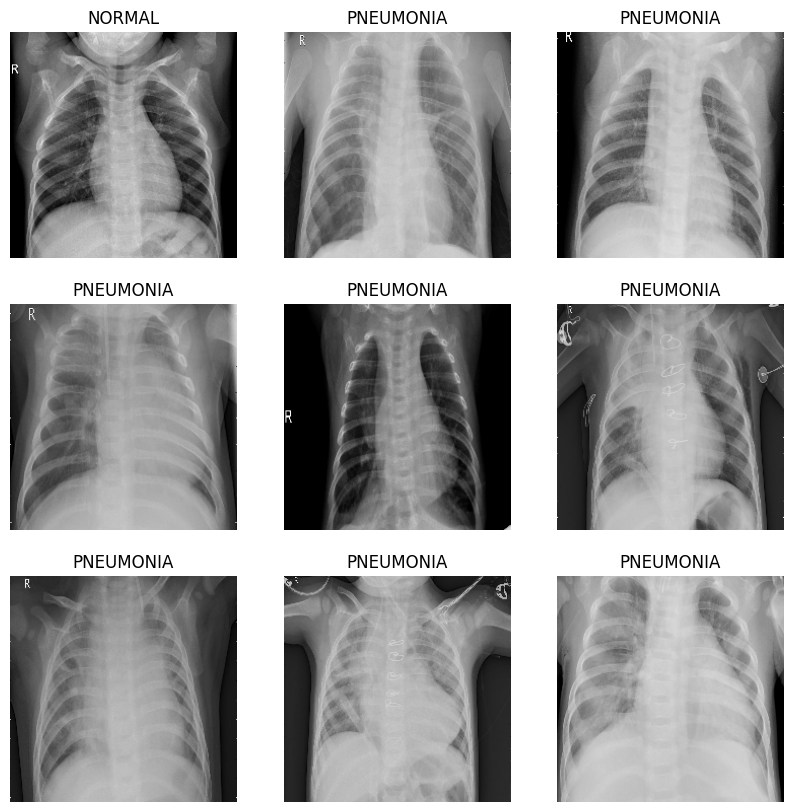

In [5]:
class_names = train_set.class_names
print(f"Class names: {class_names}")

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# Training Model on Training Set

In [6]:
# training the new layers on chest x-rays dataset
epoch_iterations = 5
history = model.fit(train_set, epochs=epoch_iterations, validation_data=validation_set)

# Fine-tuning the entire model by unfreezing all of the base model layers
model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

fine_tune_epochs = 5
total_epochs = epoch_iterations + fine_tune_epochs

history_fine = model.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set)

# Evaluate the fine-tuned model on the test set
loss, accuracy = model.evaluate(test_set)
print(f'Test accuracy: {accuracy}')

Epoch 1/5


163/163 [==============================] - 277s 2s/step - loss: 0.3184 - binary_accuracy: 0.8616 - val_loss: 0.5220 - val_binary_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 273s 2s/step - loss: 0.1991 - binary_accuracy: 0.9233 - val_loss: 0.4136 - val_binary_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 275s 2s/step - loss: 0.1744 - binary_accuracy: 0.9348 - val_loss: 0.3922 - val_binary_accuracy: 0.8750
Epoch 4/5
163/163 [==============================] - 258s 2s/step - loss: 0.1587 - binary_accuracy: 0.9381 - val_loss: 0.4674 - val_binary_accuracy: 0.8125
Epoch 5/5
163/163 [==============================] - 285s 2s/step - loss: 0.1431 - binary_accuracy: 0.9463 - val_loss: 0.3446 - val_binary_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 1133s 7s/step - loss: 0.1107 - binary_accuracy: 0.9590 - val_loss: 0.1424 - val_binary_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 896s 5s/step - los

# Checking Models Predictions on Testing Set

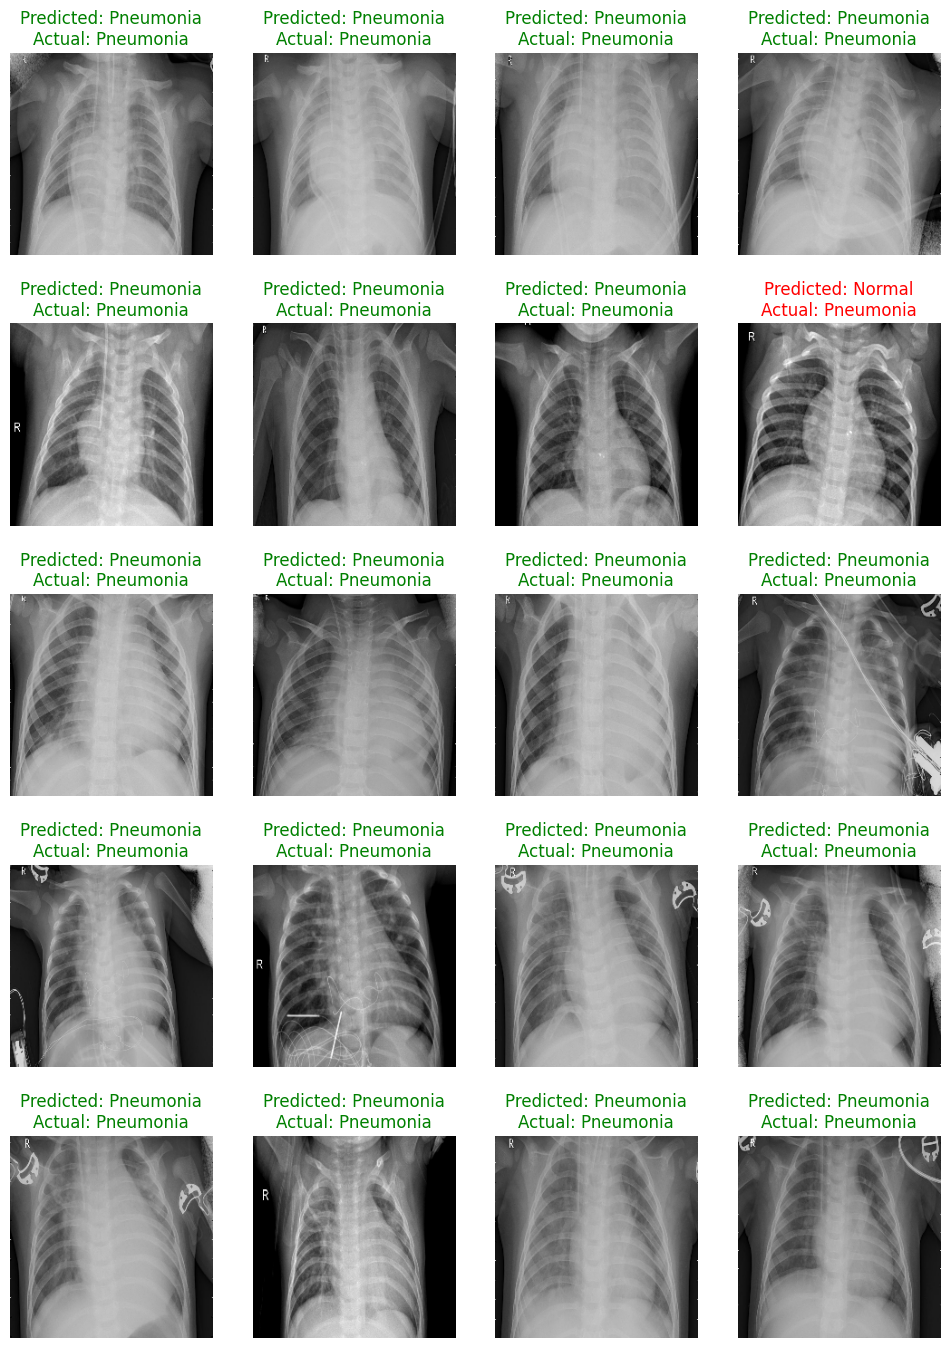

In [13]:
num_images = 20
plt.figure(figsize=(12, 17))

test_batch = random.sample(list(test_set.as_numpy_iterator()), 1)[0]
images, labels = test_batch[0], test_batch[1]

predictions = model.predict_on_batch(images)

# Getting Binary predictions
binary_predictions = (predictions > 0.5).astype(int)

for i in range(num_images):
    ax = plt.subplot(5, 4, i + 1)  
    plt.imshow(images[i].astype('uint8'))
    actual_label = "Pneumonia" if labels[i] == 1 else "Normal"
    predicted_label = "Pneumonia" if binary_predictions[i][0] == 1 else "Normal"
    title = f'Predicted: {predicted_label}\nActual: {actual_label}'
    if actual_label == predicted_label:
        plt.title(title, color='green')
    else:
        plt.title(title, color='red')
    plt.axis('off')

plt.show()

# Printing Training & Validation Loss/Accuracy of Model

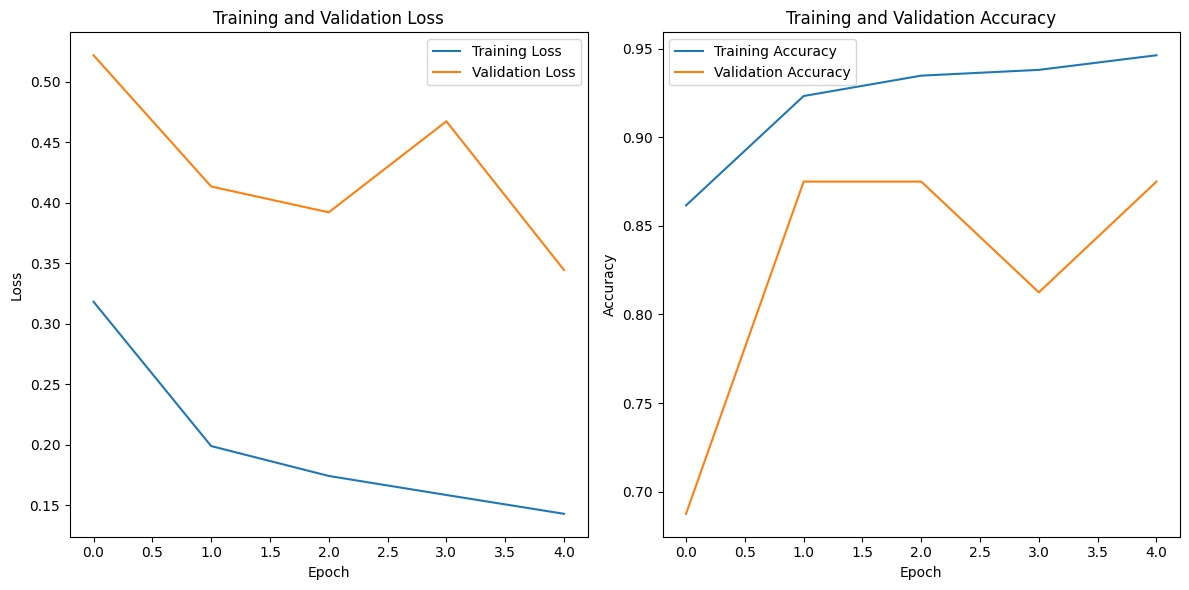

In [8]:
# training and validation history from the model training
training_loss = history.history['loss']
training_accuracy = history.history['binary_accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_binary_accuracy']

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model's  Accuracy, Precision, Recall & F1-Score

In [14]:
# Evaluating the fine-tuned model on the test set
loss, accuracy = model.evaluate(test_set)
print(f'Test accuracy: {accuracy}')

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Collect true and predicted labels for the entire test set
for images, labels in test_set:
    predictions = model.predict(images)
    predicted_labels.extend((predictions > 0.5).astype(int))
    true_labels.extend(labels)

# Converting lists to numpy arrays 
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculating Precision, Recall, F1-Score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Generating a classification report
class_names = ['Normal', 'Pneumonia']
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print(classification_rep)

20/20 [==============================] - 25s 1s/step - loss: 0.7100 - binary_accuracy: 0.8173
Test accuracy: 0.817307710647583
1/1 [==============================] - 1s 588ms/step
Precision: 0.77
Recall: 1.00
F1-Score: 0.87
              precision    recall  f1-score   support

      Normal       0.99      0.52      0.68       234
   Pneumonia       0.77      1.00      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.86      0.82      0.80       624

